# Import Libraries

In [2]:
import pandas as pd #pandas for data wrangling
import numpy as np #numpy for mathematical computations
import pyodbc
import seaborn as sns #seaborn for visualizations
import matplotlib.pyplot as plt #matplotlib for visualizations
import scipy
from scipy.stats import spearmanr 
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score,accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.pipeline import FeatureUnion, make_pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter 
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 500)             
pd.set_option('display.expand_frame_repr', False)

# Data

## Data Description
* Demographics
* Location
* Population
* Services
* Status

### Each table is described below.

**CustomerID**: A unique ID that identifies each customer.

**Gender**: The customer’s gender: Male, Female

**Age**: The customer’s current age, in years, at the time the fiscal quarter ended.

**Senior Citizen**: Indicates if the customer is 65 or older: Yes, No

**Married**: Indicates if the customer is married: Yes, No

**Dependents**: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.

**Number of Dependents**: Indicates the number of dependents that live with the customer.

**Country**: The country of the customer’s primary residence.

**State**: The state of the customer’s primary residence.

**City**: The city of the customer’s primary residence.

**Zip Code**: The zip code of the customer’s primary residence.

**Latitude**: The latitude of the customer’s primary residence.

**Longitude**: The longitude of the customer’s primary residence.

**Population**: A current population estimate for the entire Zip Code area.

**Referred a Friend**: Indicates if the customer has ever referred a friend or family member to this company: Yes, No

**Number of Referrals**: Indicates the number of referrals to date that the customer has made.

**Tenure in Months**: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.

**Offer**: Identifies the last marketing offer that the customer accepted, if applicable. Values include None, Offer A, Offer B, Offer C, Offer D, and Offer E.

**Phone Service**: Indicates if the customer subscribes to home phone service with the company: Yes, No

**Avg Monthly Long Distance Charges**: Indicates the customer’s average long distance charges, calculated to the end of the quarter specified above.

**Multiple Lines**: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No

**Internet Service**: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.

**Avg Monthly GB Download**: Indicates the customer’s average download volume in gigabytes, calculated to the end of the quarter specified above.

**Online Security**: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No

**Online Backup**: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No

**Device Protection Plan**: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No

**Premium Tech Support**: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No

**Streaming TV**: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.

**Streaming Movies**: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.

**Streaming Music**: Indicates if the customer uses their Internet service to stream music from a third party provider: Yes, No. The company does not charge an additional fee for this service.

**Unlimited Data**: Indicates if the customer has paid an additional monthly fee to have unlimited data downloads/uploads: Yes, No

**Contract**: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.

**Paperless Billing**: Indicates if the customer has chosen paperless billing: Yes, No

**Payment Method**: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check

**Monthly Charge**: Indicates the customer’s current total monthly charge for all their services from the company.

**Total Charges**: Indicates the customer’s total charges, calculated to the end of the quarter specified above.

**Total Refunds**: Indicates the customer’s total refunds, calculated to the end of the quarter specified above.

**Total Extra Data Charges**: Indicates the customer’s total charges for extra data downloads above those specified in their plan, by the end of the quarter specified above.

**Total Long Distance Charges**: Indicates the customer’s total charges for long distance above those specified in their plan, by the end of the quarter specified above.

**Satisfaction Score**: A customer’s overall satisfaction rating of the company from 1 (Very Unsatisfied) to 5 (Very Satisfied).

**Customer Status**: Indicates the status of the customer at the end of the quarter: Churned, Stayed, or Joined

**Churn Label**: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.

**Churn Value**: 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label.

**Churn Score**: A value from 0-100 that is calculated using the predictive tool IBM SPSS Modeler. The model incorporates multiple factors known to cause churn. The higher the score, the more likely the customer will churn.

**CLTV**: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.

**Churn Category**: A high-level category for the customer’s reason for churning: Attitude, Competitor, Dissatisfaction, Other, Price. When they leave the company, all customers are asked about their reasons for leaving. Directly related to Churn Reason.

**Churn Reason**: A customer’s specific reason for leaving the company. Directly related to Churn Category.

**Import Dataset From SQL**

In [29]:
conn = pyodbc.connect('DRIVER={SQL Server};'
                      'SERVER=DESKTOP-CTNELLC;'
                      'DATABASE=TelcoCustomerChurnDB2;'
                     'Trusted_Connection=yes;')

sql_for_df1 = """SELECT *
FROM [dbo].[FactCustomer] AS fact
RIGHT JOIN [dbo].[DimCustomer] AS customer
ON customer.CustomerID = fact.CustomerID
RIGHT JOIN [dbo].[DimLocation] AS loca
ON fact.LocationID = loca.LocationID
RIGHT JOIN [dbo].[DimService] AS serv
ON serv.ServiceID = fact.ServiceID
RIGHT JOIN [dbo].[DimStatus] AS stat
ON stat.StatusID = fact.StatusID
"""

df = pd.read_sql(sql_for_df1, conn)

In [30]:
df.head()

,FactID,CustomerID,LocationID,ServiceID,StatusID,SatisfactionScore,ChurnLabel,CLTV,MonthlyCharge,TotalCharges,TotalRefunds,TotalExtraDataCharges,TotalLongDistanceCharges,TotalRevenue,AvgMonthlyGBDownload,AvgMonthlyLongDistanceCharges,CustomerID,Gender,Age,Under30,SeniorCitizen,Married,Dependents,NumberOfDependents,LocationID,Country,State,City,ZipCode,Latitude,Longitude,Population,ServiceID,ReferredAFriend,NumberOfReferrals,TenureInMonths,Offer,PhoneService,AvgMonthlyLongDistanceCharges,MultipleLines,InternetService,InternetType,AvgMonthlyGBDownload,OnlineSecurity,OnlineBackup,DeviceProtectionPlan,PremiumTechSupport,StreamingTV,StreamingMovies,StreamingMusic,UnlimitedData,Contract,PaperlessBilling,PaymentMethod,MonthlyCharge,TotalCharges,TotalRefunds,TotalExtraDataCharges,TotalLongDistanceCharges,TotalRevenue,CLTV,StatusID,SatisfactionScore,CustomerStatus,ChurnLabel,ChurnValue,ChurnScore,ChurnCategory,ChurnReason
0,3183,2988-QRAJY,ARITSJ9269,EBQRARPRX3595,AAEDXJ7271,3,No,5798,110.05,7430.75,23.16,0.0,393.99,7801.58,73,5.71,2988-QRAJY,Male,27,Yes,No,No,No,0,ARITSJ9269,United States,California,Santa Rosa,95403,38.488431,-122.752839,40270,EBQRARPRX3595,No,0,69,Offer A,Yes,5.71,Yes,Yes,Fiber Optic,73,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Two Year,Yes,Credit Card,110.05,7430.75,23.16,0.0,393.99,7801.58,5798,AAEDXJ7271,3,Stayed,No,0,30,None,None
1,3454,2919-HBCJO,DHYDIP7892,QBJOZKEOS7147,AAGVIW5278,1,Yes,4580,76.65,333.60,0.00,0.0,96.36,429.96,17,24.09,2919-HBCJO,Female,36,No,No,No,No,0,DHYDIP7892,United States,California,Downieville,95936,39.578792,-120.780786,404,QBJOZKEOS7147,No,0,4,None,Yes,24.09,No,Yes,Fiber Optic,17,No,Yes,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,76.65,333.60,0.00,0.0,96.36,429.96,4580,AAGVIW5278,1,Churned,Yes,1,90,Other,Moved
2,6176,6670-MFRPK,ZQJQWP3115,CRZHCDMWV5355,AAIFDJ8638,4,No,4072,79.20,5420.65,0.00,0.0,1487.64,6908.29,17,21.56,6670-MFRPK,Male,53,No,No,Yes,Yes,1,ZQJQWP3115,United States,California,Coalinga,93210,36.186867,-120.387793,18036,CRZHCDMWV5355,Yes,5,69,Offer A,Yes,21.56,Yes,Yes,Fiber Optic,17,No,No,Yes,No,No,No,No,Yes,Two Year,Yes,Credit Card,79.20,5420.65,0.00,0.0,1487.64,6908.29,4072,AAIFDJ8638,4,Stayed,No,0,63,None,None
3,201,8519-IMDHU,IYPGCT3765,DGIECJYQD7826,AAIKCR2516,1,Yes,4981,85.60,1345.55,0.00,0.0,678.75,2024.30,22,45.25,8519-IMDHU,Male,74,No,Yes,Yes,No,0,IYPGCT3765,United States,California,Alderpoint,95511,40.166028,-123.584144,261,DGIECJYQD7826,Yes,1,15,None,Yes,45.25,Yes,Yes,Cable,22,No,No,No,No,No,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,85.60,1345.55,0.00,0.0,678.75,2024.30,4981,AAIKCR2516,1,Churned,Yes,1,83,Competitor,Competitor had better devices
4,1881,0486-LGCCH,JTITTM2455,KLMHMXZHZ1496,AAQGMP6683,3,No,3372,19.65,225.75,0.00,0.0,448.36,674.11,0,40.76,0486-LGCCH,Male,48,No,No,Yes,Yes,2,JTITTM2455,United States,California,Victorville,92394,34.567058,-117.362329,12083,KLMHMXZHZ1496,Yes,2,11,Offer D,Yes,40.76,No,No,None,0,No,No,No,No,No,No,No,No,Two Year,No,Credit Card,19.65,225.75,0.00,0.0,448.36,674.11,3372,AAQGMP6683,3,Stayed,No,0,33,None,None


## Data Wrangling

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 69 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   FactID                         7043 non-null   int64  
 1   CustomerID                     7043 non-null   object 
 2   LocationID                     7043 non-null   object 
 3   ServiceID                      7043 non-null   object 
 4   StatusID                       7043 non-null   object 
 5   SatisfactionScore              7043 non-null   int64  
 6   ChurnLabel                     7043 non-null   object 
 7   CLTV                           7043 non-null   int64  
 8   MonthlyCharge                  7043 non-null   float64
 9   TotalCharges                   7043 non-null   float64
 10  TotalRefunds                   7043 non-null   float64
 11  TotalExtraDataCharges          7043 non-null   float64
 12  TotalLongDistanceCharges       7043 non-null   f

In [33]:
df.shape

(7043, 69)

In [34]:
df.isnull().sum()

FactID                              0
CustomerID                          0
LocationID                          0
ServiceID                           0
StatusID                            0
SatisfactionScore                   0
ChurnLabel                          0
CLTV                                0
MonthlyCharge                       0
TotalCharges                        0
TotalRefunds                        0
TotalExtraDataCharges               0
TotalLongDistanceCharges            0
TotalRevenue                        0
AvgMonthlyGBDownload                0
AvgMonthlyLongDistanceCharges       0
CustomerID                          0
Gender                              0
Age                                 0
Under30                             0
SeniorCitizen                       0
Married                             0
Dependents                          0
NumberOfDependents                  0
LocationID                          0
Country                             0
State       

**We noticed some duplicate columns (even the column names were the exact same) so we had to identify them and delete them** 

In [35]:
#To identify duplicated columns
df = df.loc[:, ~df.columns.duplicated()]

# Display the first 10 rows and columns to limit the output size
print(df.iloc[:10, :10])

   FactID  CustomerID  LocationID      ServiceID    StatusID  SatisfactionScore ChurnLabel  CLTV  MonthlyCharge  TotalCharges
0    3183  2988-QRAJY  ARITSJ9269  EBQRARPRX3595  AAEDXJ7271                  3         No  5798         110.05       7430.75
1    3454  2919-HBCJO  DHYDIP7892  QBJOZKEOS7147  AAGVIW5278                  1        Yes  4580          76.65        333.60
2    6176  6670-MFRPK  ZQJQWP3115  CRZHCDMWV5355  AAIFDJ8638                  4         No  4072          79.20       5420.65
3     201  8519-IMDHU  IYPGCT3765  DGIECJYQD7826  AAIKCR2516                  1        Yes  4981          85.60       1345.55
4    1881  0486-LGCCH  JTITTM2455  KLMHMXZHZ1496  AAQGMP6683                  3         No  3372          19.65        225.75
5    6843  6968-URWQU  TKZXOT5238  GXNHEWQZN9361  AAQSNP5391                  4         No  4928          56.35       2391.15
6    1510  0104-PPXDV  YAPNWF1346  ZBYJZDPED1636  AARWWK3686                  5         No  5232          50.30       

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   FactID                         7043 non-null   int64  
 1   CustomerID                     7043 non-null   object 
 2   LocationID                     7043 non-null   object 
 3   ServiceID                      7043 non-null   object 
 4   StatusID                       7043 non-null   object 
 5   SatisfactionScore              7043 non-null   int64  
 6   ChurnLabel                     7043 non-null   object 
 7   CLTV                           7043 non-null   int64  
 8   MonthlyCharge                  7043 non-null   float64
 9   TotalCharges                   7043 non-null   float64
 10  TotalRefunds                   7043 non-null   float64
 11  TotalExtraDataCharges          7043 non-null   float64
 12  TotalLongDistanceCharges       7043 non-null   f

**Identify and drop unimportant columns**

In [38]:
df.columns

Index(['FactID', 'CustomerID', 'LocationID', 'ServiceID', 'StatusID', 'SatisfactionScore', 'ChurnLabel', 'CLTV', 'MonthlyCharge', 'TotalCharges', 'TotalRefunds', 'TotalExtraDataCharges', 'TotalLongDistanceCharges', 'TotalRevenue', 'AvgMonthlyGBDownload', 'AvgMonthlyLongDistanceCharges', 'Gender', 'Age', 'Under30', 'SeniorCitizen', 'Married', 'Dependents', 'NumberOfDependents', 'Country', 'State', 'City', 'ZipCode', 'Latitude', 'Longitude', 'Population', 'ReferredAFriend', 'NumberOfReferrals',
       'TenureInMonths', 'Offer', 'PhoneService', 'MultipleLines', 'InternetService', 'InternetType', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtectionPlan', 'PremiumTechSupport', 'StreamingTV', 'StreamingMovies', 'StreamingMusic', 'UnlimitedData', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'CustomerStatus', 'ChurnValue', 'ChurnScore', 'ChurnCategory', 'ChurnReason'],
      dtype='object')

In [39]:
#Columns to be dropped
#['FactID', 'CustomerID', 'LocationID', 'ServiceID', 'StatusID', 'Country', 'State', 'City', 'ZipCode', 'Latitude', 
#'Longitude', 'Offer', 'CustomerStatus', 'ChurnValue','ChurnScore', 'ChurnCategory', 'ChurnReason']

In [40]:
df_model = df.drop(['FactID', 'CustomerID', 'LocationID', 'ServiceID', 'StatusID', 'Country', 'State', 'City', 'ZipCode', 'Latitude', 
'Longitude', 'CustomerStatus', 'ChurnValue','ChurnScore', 'ChurnCategory', 'ChurnReason'], axis=1)

In [41]:
#For unsupervised model in the future
data = df_model

In [42]:
df_model.shape

(7043, 38)

In [43]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SatisfactionScore              7043 non-null   int64  
 1   ChurnLabel                     7043 non-null   object 
 2   CLTV                           7043 non-null   int64  
 3   MonthlyCharge                  7043 non-null   float64
 4   TotalCharges                   7043 non-null   float64
 5   TotalRefunds                   7043 non-null   float64
 6   TotalExtraDataCharges          7043 non-null   float64
 7   TotalLongDistanceCharges       7043 non-null   float64
 8   TotalRevenue                   7043 non-null   float64
 9   AvgMonthlyGBDownload           7043 non-null   int64  
 10  AvgMonthlyLongDistanceCharges  7043 non-null   float64
 11  Gender                         7043 non-null   object 
 12  Age                            7043 non-null   i

###### Encoding categorical columns

In [45]:
# Extract the categorical columns
categorical_columns = df_model.select_dtypes(include=['object', 'category']).columns

# Print the categorical columns
print("Categorical columns in the dataset are:")
print(categorical_columns)

Categorical columns in the dataset are:
Index(['ChurnLabel', 'Gender', 'Under30', 'SeniorCitizen', 'Married', 'Dependents', 'ReferredAFriend', 'Offer', 'PhoneService', 'MultipleLines', 'InternetService', 'InternetType', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtectionPlan', 'PremiumTechSupport', 'StreamingTV', 'StreamingMovies', 'StreamingMusic', 'UnlimitedData', 'Contract', 'PaperlessBilling', 'PaymentMethod'], dtype='object')


In [46]:
#Check Number of unique variables in the dataset which will guide us when creating the for loop to encode all of this data
df_model[['ChurnLabel', 'Gender', 'Under30', 'SeniorCitizen', 'Married', 'Dependents', 'ReferredAFriend', 'PhoneService', 'MultipleLines', 
          'InternetService', 'InternetType', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtectionPlan', 'PremiumTechSupport', 'StreamingTV', 
          'StreamingMovies', 'StreamingMusic', 'UnlimitedData', 'Contract', 'PaperlessBilling', 'PaymentMethod']].nunique()

ChurnLabel              2
Gender                  2
Under30                 2
SeniorCitizen           2
Married                 2
Dependents              2
ReferredAFriend         2
PhoneService            2
MultipleLines           2
InternetService         2
InternetType            4
OnlineSecurity          2
OnlineBackup            2
DeviceProtectionPlan    2
PremiumTechSupport      2
StreamingTV             2
StreamingMovies         2
StreamingMusic          2
UnlimitedData           2
Contract                3
PaperlessBilling        2
PaymentMethod           3
dtype: int64

In [47]:
# Function to encode binary categorical columns
def encode_binary_column(df, column_name):
    """
    Encodes binary categorical columns using pd.get_dummies(), drops the first column, 
    and replaces the original column with the new binary column.
    
    Args:
    df (pd.DataFrame): The input dataframe.
    column_name (str): The name of the binary categorical column to encode.
    
    Returns:
    pd.DataFrame: DataFrame with the encoded column.
    """
    # Perform one-hot encoding and drop the first column
    dummies = pd.get_dummies(df[column_name], dtype='int',drop_first=True)
    
    # Replace the old column with the new one
    df[column_name] = dummies
    return df


# Function to encode columns with multiple categories
def encode_multi_category_column(df_model, column_name):
    """
    Encodes multi-category columns using pd.get_dummies(), drops the first column, 
    and appends the resulting dummy columns to the dataframe.
    
    Args:
    df_model (pd.DataFrame): The input dataframe.
    column_name (str): The name of the multi-category column to encode.
    
    Returns:
    pd.DataFrame: DataFrame with the encoded columns appended.
    """
    # Perform one-hot encoding and drop the first column
    dummies = pd.get_dummies(df_model[column_name], dtype='int',drop_first=True, prefix=column_name)
    
    # Drop the original column and append the new encoded columns
    df_model = df_model.drop(column_name, axis=1)
    df_model = pd.concat([df_model, dummies], axis=1)
    
    return df_model

In [48]:
#Applying these functions accordingly (pay attention to the type of encoding wether nominal or ordinal)
categorical_columns = df_model.select_dtypes(include=['object', 'category']).columns

# Step 2: Loop over the categorical columns and encode them
for column in categorical_columns:
    unique_values = df_model[column].nunique()  # Get the number of unique categories
    
    if unique_values == 2:
        # If the column has exactly 2 unique categories, treat it as binary and encode
        df_model = encode_binary_column(df_model, column)
    elif unique_values > 2:
        # If the column has more than 3 unique categories, treat it as multi-category and encode
        df_model = encode_multi_category_column(df_model, column)

In [66]:
#Check if dataframe has been encoded appropriately
df_model.head()

,SatisfactionScore,ChurnLabel,CLTV,MonthlyCharge,TotalCharges,TotalRefunds,TotalExtraDataCharges,TotalLongDistanceCharges,TotalRevenue,AvgMonthlyGBDownload,AvgMonthlyLongDistanceCharges,Gender,Age,Under30,SeniorCitizen,Married,Dependents,NumberOfDependents,Population,ReferredAFriend,NumberOfReferrals,TenureInMonths,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtectionPlan,PremiumTechSupport,StreamingTV,StreamingMovies,StreamingMusic,UnlimitedData,PaperlessBilling,Offer_Offer A,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E,InternetType_DSL,InternetType_Fiber Optic,InternetType_None,Contract_One Year,Contract_Two Year,PaymentMethod_Credit Card,PaymentMethod_Mailed Check
0,3,0,5798,110.05,7430.75,23.16,0.0,393.99,7801.58,73,5.71,1,27,1,0,0,0,0,40270,0,0,69,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,1,1,0
1,1,1,4580,76.65,333.60,0.00,0.0,96.36,429.96,17,24.09,0,36,0,0,0,0,0,404,0,0,4,1,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
2,4,0,4072,79.20,5420.65,0.00,0.0,1487.64,6908.29,17,21.56,1,53,0,0,1,1,1,18036,1,5,69,1,1,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,1,1,0
3,1,1,4981,85.60,1345.55,0.00,0.0,678.75,2024.30,22,45.25,1,74,0,1,1,0,0,261,1,1,15,1,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,3,0,3372,19.65,225.75,0.00,0.0,448.36,674.11,0,40.76,1,48,0,0,1,1,2,12083,1,2,11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0


# Build Unsupervised ML Model

In [400]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

In [404]:
#Scale data
scaler = StandardScaler()
scaler.fit(df_model)

StandardScaler()

In [405]:
scaled_data = scaler.transform(df_model)

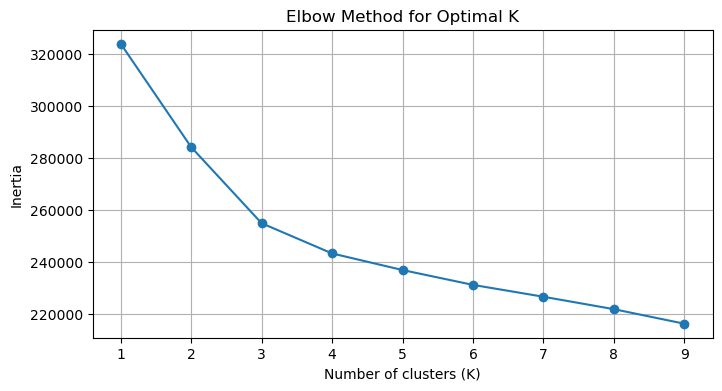

In [408]:
# Determine the optimal number of clusters (K) using the Elbow Method
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

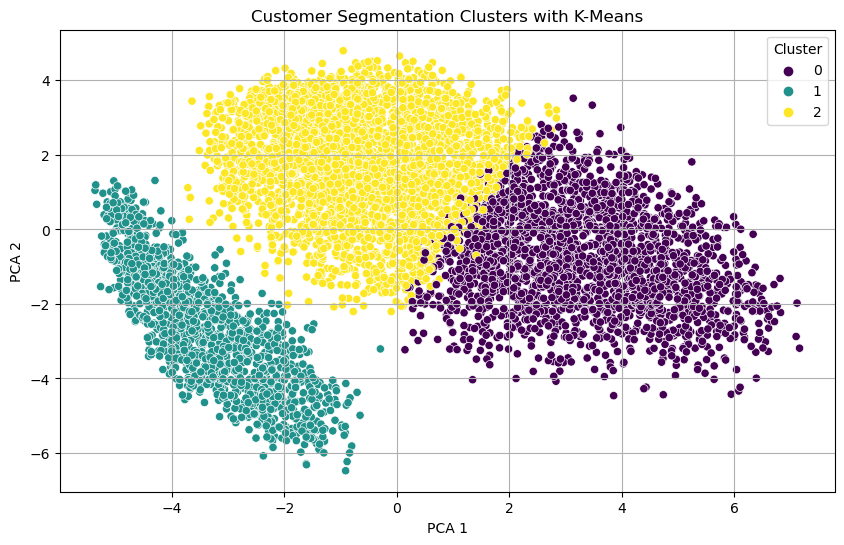

In [409]:
# Fit K-Means with the chosen number of clusters (e.g., K=2)
optimal_k = 3  # Choose the optimal K based on the Elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add cluster labels to the dataset
df_model['Kmeans_Cluster'] = clusters

# Use PCA to visualize clusters
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Kmeans_Cluster'] = df_model['Kmeans_Cluster']

# Plotting the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Kmeans_Cluster', data=pca_df, palette='viridis')
plt.title('Customer Segmentation Clusters with K-Means')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()


<Axes: xlabel='TenureInMonths', ylabel='TotalRevenue'>

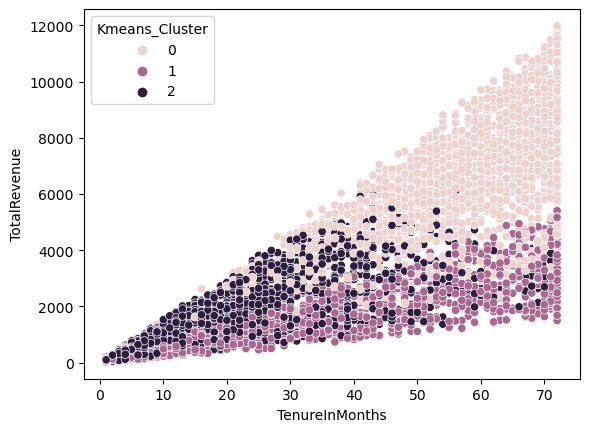

In [411]:
#Plot the clusters based on Tenure against Total revenue to get an insight on the most profitable cluster
sns.scatterplot(data = df_model, x='TenureInMonths', y='TotalRevenue',hue='Kmeans_Cluster')

# KModes Clusterring

**In theory this should work better considering our data is a combination of categorical and numeric data**

In [217]:
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [225]:
# Identify Categorical Columns
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SatisfactionScore              7043 non-null   int64  
 1   ChurnLabel                     7043 non-null   int32  
 2   CLTV                           7043 non-null   int64  
 3   MonthlyCharge                  7043 non-null   float64
 4   TotalCharges                   7043 non-null   float64
 5   TotalRefunds                   7043 non-null   float64
 6   TotalExtraDataCharges          7043 non-null   float64
 7   TotalLongDistanceCharges       7043 non-null   float64
 8   TotalRevenue                   7043 non-null   float64
 9   AvgMonthlyGBDownload           7043 non-null   int64  
 10  AvgMonthlyLongDistanceCharges  7043 non-null   float64
 11  Gender                         7043 non-null   int32  
 12  Age                            7043 non-null   i

In [ ]:
[0,1,11,13,14,15,16,19,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45]

In [250]:
# Select categorical columns for kprototypes
array = df_model.values

# Apply kprototypes Clustering
kproto = KPrototypes(n_clusters=3, init='Huang', n_init=5,random_state=42)
df_model['kprototypes_cluster'] = kproto.fit_predict(array,categorical=[0,1,11,13,14,15,16,19,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
                                                                        41,42,43,44,45])
df_model['kprototypes_cluster'] = df_model['kprototypes_cluster']

In [251]:
# Use PCA for Visualization (if you have continuous variables)
# You may want to apply PCA to your continuous variables only
scaler = StandardScaler()
pca_data = scaler.fit_transform(df_model.select_dtypes(include=[np.number]))
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_data)

In [252]:
# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['kprototypes_cluster'] = df_model['kprototypes_cluster']

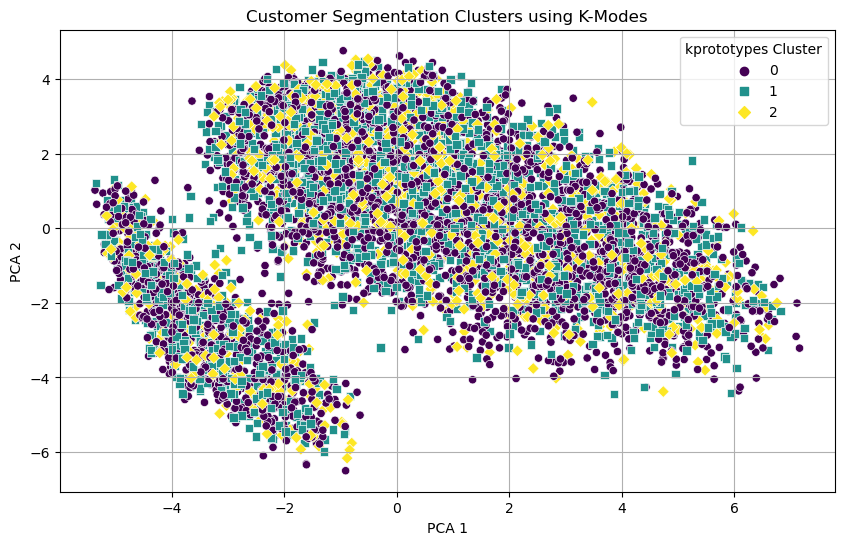

In [253]:
# Plotting K-Modes Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='kprototypes_cluster', data=pca_df, palette='viridis', style='kprototypes_cluster', markers=['o', 's', 'D'])
plt.title('Customer Segmentation Clusters using K-Modes')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='kprototypes Cluster')
plt.grid()
plt.show()

<Axes: xlabel='TenureInMonths', ylabel='TotalRevenue'>

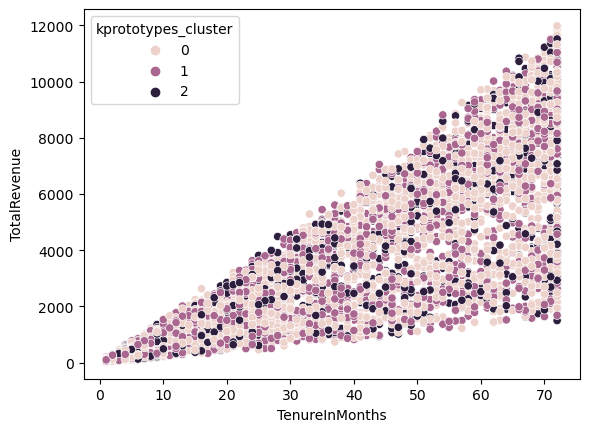

In [274]:
sns.scatterplot(data = df_model, x='TenureInMonths', y='TotalRevenue',hue='kprototypes_cluster')

# KPrototypes cluster analysis

In [276]:
df_model.columns

Index(['SatisfactionScore', 'ChurnLabel', 'CLTV', 'MonthlyCharge', 'TotalCharges', 'TotalRefunds', 'TotalExtraDataCharges', 'TotalLongDistanceCharges', 'TotalRevenue', 'AvgMonthlyGBDownload', 'AvgMonthlyLongDistanceCharges', 'Gender', 'Age', 'Under30', 'SeniorCitizen', 'Married', 'Dependents', 'NumberOfDependents', 'Population', 'ReferredAFriend', 'NumberOfReferrals', 'TenureInMonths', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtectionPlan',
       'PremiumTechSupport', 'StreamingTV', 'StreamingMovies', 'StreamingMusic', 'UnlimitedData', 'PaperlessBilling', 'Offer_Offer A', 'Offer_Offer B', 'Offer_Offer C', 'Offer_Offer D', 'Offer_Offer E', 'InternetType_DSL', 'InternetType_Fiber Optic', 'InternetType_None', 'Contract_One Year', 'Contract_Two Year', 'PaymentMethod_Credit Card', 'PaymentMethod_Mailed Check', 'kprototypes_cluster'],
      dtype='object')

In [278]:
data.columns

Index(['SatisfactionScore', 'ChurnLabel', 'CLTV', 'MonthlyCharge', 'TotalCharges', 'TotalRefunds', 'TotalExtraDataCharges', 'TotalLongDistanceCharges', 'TotalRevenue', 'AvgMonthlyGBDownload', 'AvgMonthlyLongDistanceCharges', 'Gender', 'Age', 'Under30', 'SeniorCitizen', 'Married', 'Dependents', 'NumberOfDependents', 'Population', 'ReferredAFriend', 'NumberOfReferrals', 'TenureInMonths', 'Offer', 'PhoneService', 'MultipleLines', 'InternetService', 'InternetType', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtectionPlan', 'PremiumTechSupport', 'StreamingTV', 'StreamingMovies', 'StreamingMusic', 'UnlimitedData', 'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [287]:
data['kprototypes_cluster'] = df_model['kprototypes_cluster']

### Cluster 0

In [290]:
print('Total Number of Customers in Cluster 0:', data[data['kprototypes_cluster']==0]['SeniorCitizen'].count())
print('Average Customer LifeTime Value:', data[data['kprototypes_cluster']==0]['CLTV'].mean())
print('Average Customer Satisfaction Score:',data[data['kprototypes_cluster']==0]['SatisfactionScore'].mean())
print('Average Total Revenue from Cluster 0:', data[data['kprototypes_cluster']==0]['TotalRevenue'].mean())
print('Average Customer Tenure:', data[data['kprototypes_cluster']==0]['TenureInMonths'].mean())
print('Average Total Long Distance Charges:', data[data['kprototypes_cluster']==0]['TotalLongDistanceCharges'].mean())
print('Average Total Extra Data Charges:', data[data['kprototypes_cluster']==0]['TotalExtraDataCharges'].mean())
print('Average Total Refunds:', data[data['kprototypes_cluster']==0]['TotalRefunds'].mean())
print('Average Avg Mothly Gb Downloads:', data[data['kprototypes_cluster']==0]['AvgMonthlyGBDownload'].mean())
print('Average Monthly Charges:', data[data['kprototypes_cluster']==0]['MonthlyCharge'].mean())
print('Average No of Dependents:',data[data['kprototypes_cluster']==0]['Dependents'].mean())
print('Average Age:',data[data['kprototypes_cluster']==0]['Age'].mean())
print('No of Senior Citizens:',data[data['kprototypes_cluster']==0]['SeniorCitizen'].value_counts())
print('No of People who Referred a Friend:',data[data['kprototypes_cluster']==0]['ReferredAFriend'].value_counts())
print('Contract Type:',data[data['kprototypes_cluster']==0]['Contract'].value_counts())
print('Relationship Status:',data[data['kprototypes_cluster']==0]['Married'].value_counts())
print('Choice of Payment:',data[data['kprototypes_cluster']==0]['PaymentMethod'].value_counts())
print('If they required tech support:',data[data['kprototypes_cluster']==0]['PremiumTechSupport'].value_counts())
print('Choice of Internet service:',data[data['kprototypes_cluster']==0]['InternetService'].value_counts())

Total Number of Customers in Cluster 0: 3501
Average Customer LifeTime Value: 4422.487860611254
Average Customer Satisfaction Score: 3.281633818908883
Average Total Revenue from Cluster 0: 3098.27578977435
Average Customer Tenure: 33.087403598971726
Average Total Long Distance Charges: 770.3549757212226
Average Total Extra Data Charges: 6.5552699228791775
Average Total Refunds: 1.6868694658668952
Average Avg Mothly Gb Downloads: 20.316481005427022
Average Monthly Charges: 64.54301628106255
Average No of Dependents: 0.24250214224507283
Average Age: 46.80405598400457
No of Senior Citizens: SeniorCitizen
0    2917
1     584
Name: count, dtype: int64
No of People who Referred a Friend: ReferredAFriend
0    1868
1    1633
Name: count, dtype: int64
Contract Type: Contract
Month-to-Month    1743
Two Year           973
One Year           785
Name: count, dtype: int64
Relationship Status: Married
0    1776
1    1725
Name: count, dtype: int64
Choice of Payment: PaymentMethod
Bank Withdrawal    1

# Cluster 1

In [293]:
print('Total Number of Customers in Cluster 1:', data[data['kprototypes_cluster']==1]['SeniorCitizen'].count())
print('Average Customer LifeTime Value:', data[data['kprototypes_cluster']==1]['CLTV'].mean())
print('Average Customer Satisfaction Score:', data[data['kprototypes_cluster']==1]['SatisfactionScore'].mean())
print('Average Total Revenue from Cluster 1:', data[data['kprototypes_cluster']==1]['TotalRevenue'].mean())
print('Average Customer Tenure:', data[data['kprototypes_cluster']==1]['TenureInMonths'].mean())
print('Average Total Long Distance Charges:', data[data['kprototypes_cluster']==1]['TotalLongDistanceCharges'].mean())
print('Average Total Extra Data Charges:', data[data['kprototypes_cluster']==1]['TotalExtraDataCharges'].mean())
print('Average Total Refunds:', data[data['kprototypes_cluster']==1]['TotalRefunds'].mean())
print('Average Avg Monthly GB Downloads:', data[data['kprototypes_cluster']==1]['AvgMonthlyGBDownload'].mean())
print('Average Monthly Charges:', data[data['kprototypes_cluster']==1]['MonthlyCharge'].mean())
print('Average No of Dependents:', data[data['kprototypes_cluster']==1]['Dependents'].mean())
print('Average Age:', data[data['kprototypes_cluster']==1]['Age'].mean())
print('No of Senior Citizens:', data[data['kprototypes_cluster']==1]['SeniorCitizen'].value_counts())
print('No of People who Referred a Friend:', data[data['kprototypes_cluster']==1]['ReferredAFriend'].value_counts())
print('Contract Type:', data[data['kprototypes_cluster']==1]['Contract'].value_counts())
print('Relationship Status:', data[data['kprototypes_cluster']==1]['Married'].value_counts())
print('Choice of Payment:', data[data['kprototypes_cluster']==1]['PaymentMethod'].value_counts())
print('If they required tech support:', data[data['kprototypes_cluster']==1]['PremiumTechSupport'].value_counts())
print('Choice of Internet service:', data[data['kprototypes_cluster']==1]['InternetService'].value_counts())

Total Number of Customers in Cluster 1: 2308
Average Customer LifeTime Value: 4347.929376083189
Average Customer Satisfaction Score: 3.2417677642980935
Average Total Revenue from Cluster 1: 2921.1582495667244
Average Customer Tenure: 31.171143847487002
Average Total Long Distance Charges: 722.9196967071057
Average Total Extra Data Charges: 7.209705372616984
Average Total Refunds: 2.35459705372617
Average Avg Monthly GB Downloads: 20.12261698440208
Average Monthly Charges: 64.66410311958406
Average No of Dependents: 0.21967071057192375
Average Age: 46.22010398613518
No of Senior Citizens: SeniorCitizen
0    1959
1     349
Name: count, dtype: int64
No of People who Referred a Friend: ReferredAFriend
0    1299
1    1009
Name: count, dtype: int64
Contract Type: Contract
Month-to-Month    1245
Two Year           579
One Year           484
Name: count, dtype: int64
Relationship Status: Married
0    1235
1    1073
Name: count, dtype: int64
Choice of Payment: PaymentMethod
Bank Withdrawal    1

# Cluster 2

In [296]:
print('Total Number of Customers in Cluster 2:', data[data['kprototypes_cluster']==2]['SeniorCitizen'].count())
print('Average Customer LifeTime Value:', data[data['kprototypes_cluster']==2]['CLTV'].mean())
print('Average Customer Satisfaction Score:', data[data['kprototypes_cluster']==2]['SatisfactionScore'].mean())
print('Average Total Revenue from Cluster 2:', data[data['kprototypes_cluster']==2]['TotalRevenue'].mean())
print('Average Customer Tenure:', data[data['kprototypes_cluster']==2]['TenureInMonths'].mean())
print('Average Total Long Distance Charges:', data[data['kprototypes_cluster']==2]['TotalLongDistanceCharges'].mean())
print('Average Total Extra Data Charges:', data[data['kprototypes_cluster']==2]['TotalExtraDataCharges'].mean())
print('Average Total Refunds:', data[data['kprototypes_cluster']==2]['TotalRefunds'].mean())
print('Average Avg Monthly GB Downloads:', data[data['kprototypes_cluster']==2]['AvgMonthlyGBDownload'].mean())
print('Average Monthly Charges:', data[data['kprototypes_cluster']==2]['MonthlyCharge'].mean())
print('Average No of Dependents:', data[data['kprototypes_cluster']==2]['Dependents'].mean())
print('Average Age:', data[data['kprototypes_cluster']==2]['Age'].mean())
print('No of Senior Citizens:', data[data['kprototypes_cluster']==2]['SeniorCitizen'].value_counts())
print('No of People who Referred a Friend:', data[data['kprototypes_cluster']==2]['ReferredAFriend'].value_counts())
print('Contract Type:', data[data['kprototypes_cluster']==2]['Contract'].value_counts())
print('Relationship Status:', data[data['kprototypes_cluster']==2]['Married'].value_counts())
print('Choice of Payment:', data[data['kprototypes_cluster']==2]['PaymentMethod'].value_counts())
print('If they required tech support:', data[data['kprototypes_cluster']==2]['PremiumTechSupport'].value_counts())
print('Choice of Internet service:', data[data['kprototypes_cluster']==2]['InternetService'].value_counts())

Total Number of Customers in Cluster 2: 1234
Average Customer LifeTime Value: 4435.277147487845
Average Customer Satisfaction Score: 3.146677471636953
Average Total Revenue from Cluster 2: 3064.858111831443
Average Customer Tenure: 32.67260940032415
Average Total Long Distance Charges: 737.7590518638573
Average Total Extra Data Charges: 7.074554294975689
Average Total Refunds: 2.009327390599676
Average Avg Monthly GB Downloads: 21.81442463533225
Average Monthly Charges: 65.56462722852513
Average No of Dependents: 0.21961102106969205
Average Age: 46.216369529983794
No of Senior Citizens: SeniorCitizen
0    1025
1     209
Name: count, dtype: int64
No of People who Referred a Friend: ReferredAFriend
0    654
1    580
Name: count, dtype: int64
Contract Type: Contract
Month-to-Month    622
Two Year          331
One Year          281
Name: count, dtype: int64
Relationship Status: Married
0    630
1    604
Name: count, dtype: int64
Choice of Payment: PaymentMethod
Bank Withdrawal    713
Credi

# Pen Portrait



### **Cluster 0: The Loyal Pragmatists**

**Characteristics**:
- **Customer Count**: 3,501
- **Lifetime Value**: High ($4,422)
- **Satisfaction**: Moderate (3.28/5)
- **Tenure**: Long (33 months)
- **Monthly Revenue**: Moderate ($64.54)
- **Demographics**: Older (average age 46.8), mostly non-senior citizens
- **Contract Preferences**: Mixed, with a slight preference for Month-to-Month
- **Payment Preferences**: Primarily Bank Withdrawal, some use Credit Cards
- **Tech Support Use**: Lower (29.6% use premium support)
- **Internet Service**: 78% subscribe to internet services

**Pen Portrait**:
Cluster 0 represents seasoned, moderately satisfied customers who maintain long-term relationships with the company, indicating loyalty. However, they seem cost-conscious, choosing mostly Month-to-Month contracts. They likely value flexibility, and while they aren't heavy tech support users, they benefit from internet services and only have a modest number of dependents. This group is also less likely to refer new customers.

**Profitability Improvement Strategies**:
1. **Upsell Annual Contracts**: Offer targeted promotions for one-year or two-year contracts with small discounts to shift month-to-month users to more profitable, longer-term plans.
2. **Loyalty Program for Referrals**: Develop a referral incentive specifically for this cluster to increase word-of-mouth marketing.
3. **Targeted Offers for Additional Services**: Since they aren’t high tech-support users, introduce bundled services that enhance their current package, like a tech-support discount or add-on features.
4. **Engagement Programs**: Offer periodic rewards based on tenure or satisfaction milestones to boost loyalty and increase overall satisfaction.

---

### **Cluster 1: The Standard Subscribers**

**Characteristics**:
- **Customer Count**: 2,308
- **Lifetime Value**: Moderate ($4,347)
- **Satisfaction**: Moderate (3.24/5)
- **Tenure**: Moderate (31 months)
- **Monthly Revenue**: Moderate ($64.66)
- **Demographics**: Mature (average age 46.2), predominantly younger than senior citizens
- **Contract Preferences**: Mostly Month-to-Month, with some preference for two-year contracts
- **Payment Preferences**: Prefer Bank Withdrawals, followed by Credit Cards
- **Tech Support Use**: Moderate (27.5% use premium support)
- **Internet Service**: 78% subscribe to internet services

**Pen Portrait**:
Cluster 1 includes steady, moderately satisfied customers with average lifetime value and tenure. They are cost-aware, with a slight inclination toward longer contracts but primarily use Month-to-Month. This group has some dependency on tech support and is open to internet services, indicating a preference for convenience but not necessarily a strong loyalty.

**Profitability Improvement Strategies**:
1. **Promote Premium Support Packages**: Upsell tech support or additional assistance packages, possibly as part of a monthly bundle, to those already using it and encourage non-users to try the premium services.
2. **Annual Contract Incentives**: Introduce a loyalty program specifically for Month-to-Month customers, rewarding those who switch to annual contracts.
3. **Value-Added Services for Internet Users**: Since this group heavily uses internet services, promote faster or more data-intensive plans for moderate additional charges.
4. **Feedback-Driven Satisfaction Initiatives**: Conduct satisfaction surveys to identify specific improvement areas for Cluster 1 to increase their satisfaction and potentially, lifetime value.

---

### **Cluster 2: The Data-Driven Dependents**

**Characteristics**:
- **Customer Count**: 1,234
- **Lifetime Value**: High ($4,435)
- **Satisfaction**: Lower (3.15/5)
- **Tenure**: Moderate (32 months)
- **Monthly Revenue**: Slightly Higher ($65.56)
- **Demographics**: Mature (average age 46.2), primarily non-senior citizens
- **Contract Preferences**: Mostly Month-to-Month, some Two-Year
- **Payment Preferences**: Bank Withdrawal and Credit Card
- **Tech Support Use**: Moderate (30.3% use premium support)
- **Internet Service**: High demand (80%)

**Pen Portrait**:
Cluster 2 comprises a highly data-driven customer base with higher lifetime value but slightly lower satisfaction scores. These customers are moderate in tenure and have a slightly higher average revenue per month. Their higher internet and tech support use signals that they may be dependent on these services, and they prefer flexible payment options and Month-to-Month contracts.

**Profitability Improvement Strategies**:
1. **Enhance Internet and Data Offerings**: Since data and internet are essential for this group, introducing new high-speed or data-heavy plans could be attractive. Personalized promotions, like discounts for higher data usage or priority tech support, may appeal to them.
2. **Increase Satisfaction Through Customization**: Work on enhancing customer satisfaction by introducing customizable plans where customers can select services relevant to them, which could reduce dissatisfaction.
3. **Switch to Long-Term Contracts**: This cluster would benefit from incentives for longer contract commitments. Offer a month-to-month to annual contract switch incentive to increase retention.
4. **Premium Engagement Programs**: Given their data reliance, add value by offering free trials for advanced support, as this group may appreciate early access or loyalty perks related to tech services.

---

These portraits and strategies provide a roadmap to tailoring services to each cluster’s needs, potentially boosting satisfaction and increasing customer retention and profitability.

# Kmeans Cluster Analysis

In [515]:
data['kmeans_cluster'] = df_model['Kmeans_Cluster']

### Cluster 0

In [509]:
df_model.columns

Index(['SatisfactionScore', 'ChurnLabel', 'CLTV', 'MonthlyCharge', 'TotalCharges', 'TotalRefunds', 'TotalExtraDataCharges', 'TotalLongDistanceCharges', 'TotalRevenue', 'AvgMonthlyGBDownload', 'AvgMonthlyLongDistanceCharges', 'Gender', 'Age', 'Under30', 'SeniorCitizen', 'Married', 'Dependents', 'NumberOfDependents', 'Population', 'ReferredAFriend', 'NumberOfReferrals', 'TenureInMonths', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtectionPlan',
       'PremiumTechSupport', 'StreamingTV', 'StreamingMovies', 'StreamingMusic', 'UnlimitedData', 'PaperlessBilling', 'Offer_Offer A', 'Offer_Offer B', 'Offer_Offer C', 'Offer_Offer D', 'Offer_Offer E', 'InternetType_DSL', 'InternetType_Fiber Optic', 'InternetType_None', 'Contract_One Year', 'Contract_Two Year', 'PaymentMethod_Credit Card', 'PaymentMethod_Mailed Check', 'Kmeans_Cluster'],
      dtype='object')

In [517]:
print('Total Number of Customers in Cluster 0:', data[data['kmeans_cluster']==0]['SeniorCitizen'].count())
print('Average Customer LifeTime Value:', data[data['kmeans_cluster']==0]['CLTV'].mean())
print('Average Customer Satisfaction Score:',data[data['kmeans_cluster']==0]['SatisfactionScore'].mean())
print('Average Total Revenue from Cluster 0:', data[data['kmeans_cluster']==0]['TotalRevenue'].mean())
print('Average Customer Tenure:', data[data['kmeans_cluster']==0]['TenureInMonths'].mean())
print('Average Total Long Distance Charges:', data[data['kmeans_cluster']==0]['TotalLongDistanceCharges'].mean())
print('Average Total Extra Data Charges:', data[data['kmeans_cluster']==0]['TotalExtraDataCharges'].mean())
print('Average Total Refunds:', data[data['kmeans_cluster']==0]['TotalRefunds'].mean())
print('Average Avg Mothly Gb Downloads:', data[data['kmeans_cluster']==0]['AvgMonthlyGBDownload'].mean())
print('Average Monthly Charges:', data[data['kmeans_cluster']==0]['MonthlyCharge'].mean())
print('Average No of Dependents:',data[data['kmeans_cluster']==0]['Dependents'].mean())
print('Average Age:',data[data['kmeans_cluster']==0]['Age'].mean())
print('No of Senior Citizens:',data[data['kmeans_cluster']==0]['SeniorCitizen'].value_counts())
print('No of People who Referred a Friend:',data[data['kmeans_cluster']==0]['ReferredAFriend'].value_counts())
print('Contract Type:',data[data['kmeans_cluster']==0]['Contract'].value_counts())
print('Relationship Status:',data[data['kmeans_cluster']==0]['Married'].value_counts())
print('Choice of Payment:',data[data['kmeans_cluster']==0]['PaymentMethod'].value_counts())
print('If they required tech support:',data[data['kmeans_cluster']==0]['PremiumTechSupport'].value_counts())
print('Choice of Internet service:',data[data['kmeans_cluster']==0]['InternetService'].value_counts())

Total Number of Customers in Cluster 0: 2256
Average Customer LifeTime Value: 4931.215425531915
Average Customer Satisfaction Score: 3.4250886524822697
Average Total Revenue from Cluster 0: 6499.16835106383
Average Customer Tenure: 56.844858156028366
Average Total Long Distance Charges: 1403.8251684397164
Average Total Extra Data Charges: 11.294326241134751
Average Total Refunds: 2.4313297872340427
Average Avg Mothly Gb Downloads: 27.87721631205674
Average Monthly Charges: 89.30538563829788
Average No of Dependents: 0.2801418439716312
Average Age: 46.8834219858156
No of Senior Citizens: SeniorCitizen
0    1820
1     436
Name: count, dtype: int64
No of People who Referred a Friend: ReferredAFriend
1    1589
0     667
Name: count, dtype: int64
Contract Type: Contract
Two Year          1020
One Year           776
Month-to-Month     460
Name: count, dtype: int64
Relationship Status: Married
1    1661
0     595
Name: count, dtype: int64
Choice of Payment: PaymentMethod
Bank Withdrawal    13

In [519]:
print('Total Number of Customers in Cluster 1:', data[data['kmeans_cluster']==1]['SeniorCitizen'].count())
print('Average Customer LifeTime Value:', data[data['kmeans_cluster']==1]['CLTV'].mean())
print('Average Customer Satisfaction Score:', data[data['kmeans_cluster']==1]['SatisfactionScore'].mean())
print('Average Total Revenue from Cluster 1:', data[data['kmeans_cluster']==1]['TotalRevenue'].mean())
print('Average Customer Tenure:', data[data['kmeans_cluster']==1]['TenureInMonths'].mean())
print('Average Total Long Distance Charges:', data[data['kmeans_cluster']==1]['TotalLongDistanceCharges'].mean())
print('Average Total Extra Data Charges:', data[data['kmeans_cluster']==1]['TotalExtraDataCharges'].mean())
print('Average Total Refunds:', data[data['kmeans_cluster']==1]['TotalRefunds'].mean())
print('Average Avg Monthly GB Downloads:', data[data['kmeans_cluster']==1]['AvgMonthlyGBDownload'].mean())
print('Average Monthly Charges:', data[data['kmeans_cluster']==1]['MonthlyCharge'].mean())
print('Average No of Dependents:', data[data['kmeans_cluster']==1]['Dependents'].mean())
print('Average Age:', data[data['kmeans_cluster']==1]['Age'].mean())
print('No of Senior Citizens:', data[data['kmeans_cluster']==1]['SeniorCitizen'].value_counts())
print('No of People who Referred a Friend:', data[data['kmeans_cluster']==1]['ReferredAFriend'].value_counts())
print('Contract Type:', data[data['kmeans_cluster']==1]['Contract'].value_counts())
print('Relationship Status:', data[data['kmeans_cluster']==1]['Married'].value_counts())
print('Choice of Payment:', data[data['kmeans_cluster']==1]['PaymentMethod'].value_counts())
print('If they required tech support:', data[data['kmeans_cluster']==1]['PremiumTechSupport'].value_counts())
print('Choice of Internet service:', data[data['kmeans_cluster']==1]['InternetService'].value_counts())

Total Number of Customers in Cluster 1: 1528
Average Customer LifeTime Value: 4375.717277486911
Average Customer Satisfaction Score: 3.850130890052356
Average Total Revenue from Cluster 1: 1433.4951636125656
Average Customer Tenure: 30.596858638743456
Average Total Long Distance Charges: 770.2006479057591
Average Total Extra Data Charges: 0.17670157068062828
Average Total Refunds: 1.651780104712042
Average Avg Monthly GB Downloads: 0.024869109947643978
Average Monthly Charges: 21.11325261780105
Average No of Dependents: 0.36976439790575916
Average Age: 42.77879581151832
No of Senior Citizens: SeniorCitizen
0    1476
1      52
Name: count, dtype: int64
No of People who Referred a Friend: ReferredAFriend
0    832
1    696
Name: count, dtype: int64
Contract Type: Contract
Two Year          642
Month-to-Month    519
One Year          367
Name: count, dtype: int64
Relationship Status: Married
0    788
1    740
Name: count, dtype: int64
Choice of Payment: PaymentMethod
Credit Card        931

In [521]:
print('Total Number of Customers in Cluster 2:', data[data['kmeans_cluster']==2]['SeniorCitizen'].count())
print('Average Customer LifeTime Value:', data[data['kmeans_cluster']==2]['CLTV'].mean())
print('Average Customer Satisfaction Score:', data[data['kmeans_cluster']==2]['SatisfactionScore'].mean())
print('Average Total Revenue from Cluster 2:', data[data['kmeans_cluster']==2]['TotalRevenue'].mean())
print('Average Customer Tenure:', data[data['kmeans_cluster']==2]['TenureInMonths'].mean())
print('Average Total Long Distance Charges:', data[data['kmeans_cluster']==2]['TotalLongDistanceCharges'].mean())
print('Average Total Extra Data Charges:', data[data['kmeans_cluster']==2]['TotalExtraDataCharges'].mean())
print('Average Total Refunds:', data[data['kmeans_cluster']==2]['TotalRefunds'].mean())
print('Average Avg Monthly GB Downloads:', data[data['kmeans_cluster']==2]['AvgMonthlyGBDownload'].mean())
print('Average Monthly Charges:', data[data['kmeans_cluster']==2]['MonthlyCharge'].mean())
print('Average No of Dependents:', data[data['kmeans_cluster']==2]['Dependents'].mean())
print('Average Age:', data[data['kmeans_cluster']==2]['Age'].mean())
print('No of Senior Citizens:', data[data['kmeans_cluster']==2]['SeniorCitizen'].value_counts())
print('No of People who Referred a Friend:', data[data['kmeans_cluster']==2]['ReferredAFriend'].value_counts())
print('Contract Type:', data[data['kmeans_cluster']==2]['Contract'].value_counts())
print('Relationship Status:', data[data['kmeans_cluster']==2]['Married'].value_counts())
print('Choice of Payment:', data[data['kmeans_cluster']==2]['PaymentMethod'].value_counts())
print('If they required tech support:', data[data['kmeans_cluster']==2]['PremiumTechSupport'].value_counts())
print('Choice of Internet service:', data[data['kmeans_cluster']==2]['InternetService'].value_counts())


Total Number of Customers in Cluster 2: 3259
Average Customer LifeTime Value: 4044.297330469469
Average Customer Satisfaction Score: 2.836452899662473
Average Total Revenue from Cluster 2: 1386.5072967167844
Average Customer Tenure: 16.295182571340902
Average Total Long Distance Charges: 285.9803405952746
Average Total Extra Data Charges: 6.925437250690396
Average Total Refunds: 1.7829548941393065
Average Avg Monthly GB Downloads: 25.026388462718625
Average Monthly Charges: 68.23645289966247
Average No of Dependents: 0.13194231359312672
Average Age: 48.00030684258975
No of Senior Citizens: SeniorCitizen
0    2605
1     654
Name: count, dtype: int64
No of People who Referred a Friend: ReferredAFriend
0    2322
1     937
Name: count, dtype: int64
Contract Type: Contract
Month-to-Month    2631
One Year           407
Two Year           221
Name: count, dtype: int64
Relationship Status: Married
0    2258
1    1001
Name: count, dtype: int64
Choice of Payment: PaymentMethod
Bank Withdrawal   

# Pen Portrait (Kmeans Cluster)

### **Cluster 0: The Loyal Bundlers**

**Characteristics**:
- **Customer Count**: 2,256  
- **Lifetime Value**: High ($4,931)  
- **Satisfaction**: Moderate (3.43/5)  
- **Tenure**: Long (57 months)  
- **Monthly Charges**: High ($89.31)  
- **Demographics**: Mature customers, average age 46.9, with 19% being senior citizens.  
- **Dependents**: Few (0.28 on average).  
- **Referral Status**: 70% referred a friend.  
- **Contract Type**: Two-Year (45%), One-Year (34%), Month-to-Month (21%).  
- **Payment Preferences**: Bank Withdrawal (61%), Credit Card (38%), Mailed Checks (1%).  
- **Tech Support**: 58% use premium support.  
- **Internet Service**: All customers subscribe.  

**Pen Portrait**:  
Cluster 0 represents loyal, long-term customers who are engaged with the company's services. They are cost-aware but maintain high-value contracts. They value stability and consistently refer friends, indicating satisfaction. Most use bank withdrawals and benefit from internet services, though their satisfaction could be improved.  

**Profitability Improvement Strategies**:  
1. **Reward Long-Term Loyalty**: Offer exclusive rewards, discounts, or tiered loyalty perks to Two-Year and One-Year contract customers.  
2. **Upsell Premium Features**: Target non-premium tech support users with discounts for bundled packages.  
3. **Referral Programs**: Encourage more referrals by offering dual-sided incentives.  
4. **Satisfaction Surveys**: Focus on feedback from this cluster to identify small service tweaks to boost satisfaction.  

---

### **Cluster 1: The Frugal Tech-Free Cohort**

**Characteristics**:  
- **Customer Count**: 1,528  
- **Lifetime Value**: Moderate ($4,376)  
- **Satisfaction**: High (3.85/5)  
- **Tenure**: Moderate (31 months)  
- **Monthly Charges**: Low ($21.11)  
- **Demographics**: Younger (average age 42.8), mostly non-senior citizens.  
- **Dependents**: Some (0.37 on average).  
- **Referral Status**: 54% have not referred a friend.  
- **Contract Type**: Two-Year (42%), Month-to-Month (34%), One-Year (24%).  
- **Payment Preferences**: Credit Card (61%), Bank Withdrawal (30%), Mailed Checks (9%).  
- **Tech Support**: None use premium support.  
- **Internet Service**: Predominantly no internet service.  

**Pen Portrait**:  
Cluster 1 includes frugal customers who prefer low-cost, limited services. Their high satisfaction comes from minimal expectations, and they favor contracts with moderate commitment. Their lack of tech and internet service use suggests a low-tech lifestyle or competing providers.  

**Profitability Improvement Strategies**:  
1. **Introduce Value Add-Ons**: Offer affordable, entry-level internet or tech support services.  
2. **Reward Contract Upgrades**: Incentivize Month-to-Month users to commit to One-Year or Two-Year plans.  
3. **Engage with Cross-Selling**: Leverage their satisfaction to cross-sell affordable packages for other services.  
4. **Digital Literacy Campaigns**: Educate this group on the benefits of internet and tech services.  

---

### **Cluster 2: The Budget-Conscious Explorers**

**Characteristics**:  
- **Customer Count**: 3,259  
- **Lifetime Value**: Low ($4,044)  
- **Satisfaction**: Low (2.84/5)  
- **Tenure**: Short (16 months)  
- **Monthly Charges**: Moderate ($68.24)  
- **Demographics**: Older (average age 48), with 20% being senior citizens.  
- **Dependents**: Few (0.13 on average).  
- **Referral Status**: 71% did not refer a friend.  
- **Contract Type**: Month-to-Month (81%), One-Year (12%), Two-Year (7%).  
- **Payment Preferences**: Bank Withdrawal (64%), Credit Card (30%), Mailed Checks (6%).  
- **Tech Support**: Mostly avoid premium support (77%).  
- **Internet Service**: All customers subscribe.  

**Pen Portrait**:  
Cluster 2 includes short-tenure, budget-conscious customers who are still exploring the company’s offerings. Their dissatisfaction and lack of referrals indicate a need for improved engagement. They value flexibility, as most prefer Month-to-Month contracts.  

**Profitability Improvement Strategies**:  
1. **Targeted Retention Offers**: Provide discounts or bonuses to encourage them to switch to longer-term contracts.  
2. **Improved Onboarding Experience**: Implement initiatives to enhance their satisfaction during the initial months of service.  
3. **Feedback-Driven Customization**: Offer customizable packages to align better with their needs.  
4. **Digital Engagement Campaigns**: Leverage their internet usage to offer value-added services, such as faster internet or entertainment bundles.  

---


# Survival Analysis

In [74]:
# Import Libraries
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

In [70]:
data.head()

,SatisfactionScore,ChurnLabel,CLTV,MonthlyCharge,TotalCharges,TotalRefunds,TotalExtraDataCharges,TotalLongDistanceCharges,TotalRevenue,AvgMonthlyGBDownload,AvgMonthlyLongDistanceCharges,Gender,Age,Under30,SeniorCitizen,Married,Dependents,NumberOfDependents,Population,ReferredAFriend,NumberOfReferrals,TenureInMonths,Offer,PhoneService,MultipleLines,InternetService,InternetType,OnlineSecurity,OnlineBackup,DeviceProtectionPlan,PremiumTechSupport,StreamingTV,StreamingMovies,StreamingMusic,UnlimitedData,Contract,PaperlessBilling,PaymentMethod
0,3,0,5798,110.05,7430.75,23.16,0.0,393.99,7801.58,73,5.71,1,27,1,0,0,0,0,40270,0,0,69,Offer A,Yes,Yes,Yes,Fiber Optic,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Two Year,Yes,Credit Card
1,1,1,4580,76.65,333.60,0.00,0.0,96.36,429.96,17,24.09,0,36,0,0,0,0,0,404,0,0,4,None,Yes,No,Yes,Fiber Optic,No,Yes,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal
2,4,0,4072,79.20,5420.65,0.00,0.0,1487.64,6908.29,17,21.56,1,53,0,0,1,1,1,18036,1,5,69,Offer A,Yes,Yes,Yes,Fiber Optic,No,No,Yes,No,No,No,No,Yes,Two Year,Yes,Credit Card
3,1,1,4981,85.60,1345.55,0.00,0.0,678.75,2024.30,22,45.25,1,74,0,1,1,0,0,261,1,1,15,None,Yes,Yes,Yes,Cable,No,No,No,No,No,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal
4,3,0,3372,19.65,225.75,0.00,0.0,448.36,674.11,0,40.76,1,48,0,0,1,1,2,12083,1,2,11,Offer D,Yes,No,No,None,No,No,No,No,No,No,No,No,Two Year,No,Credit Card


Text(0, 0.5, 'Survival probability')

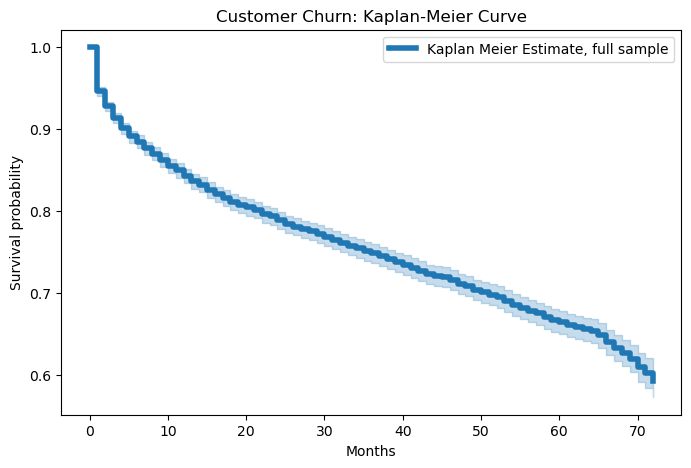

In [111]:
#Kaplan meier plot
kmf = KaplanMeierFitter()

kmf.fit(data['TenureInMonths'], data['ChurnLabel'], label = 'Kaplan Meier Estimate, full sample')

kmf.plot(linewidth=4, figsize=(8, 5))
plt.title('Customer Churn: Kaplan-Meier Curve')
plt.xlabel('Months')
plt.ylabel('Survival probability')

<Axes: xlabel='timeline'>

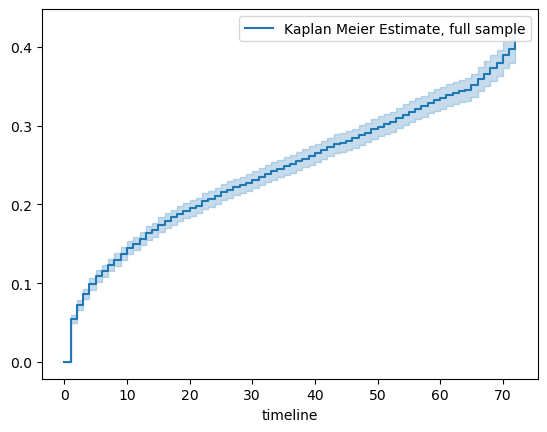

In [113]:
#Cumulative density plot
kmf.plot_cumulative_density()

# Kaplan Meier Model Based on Contract Length

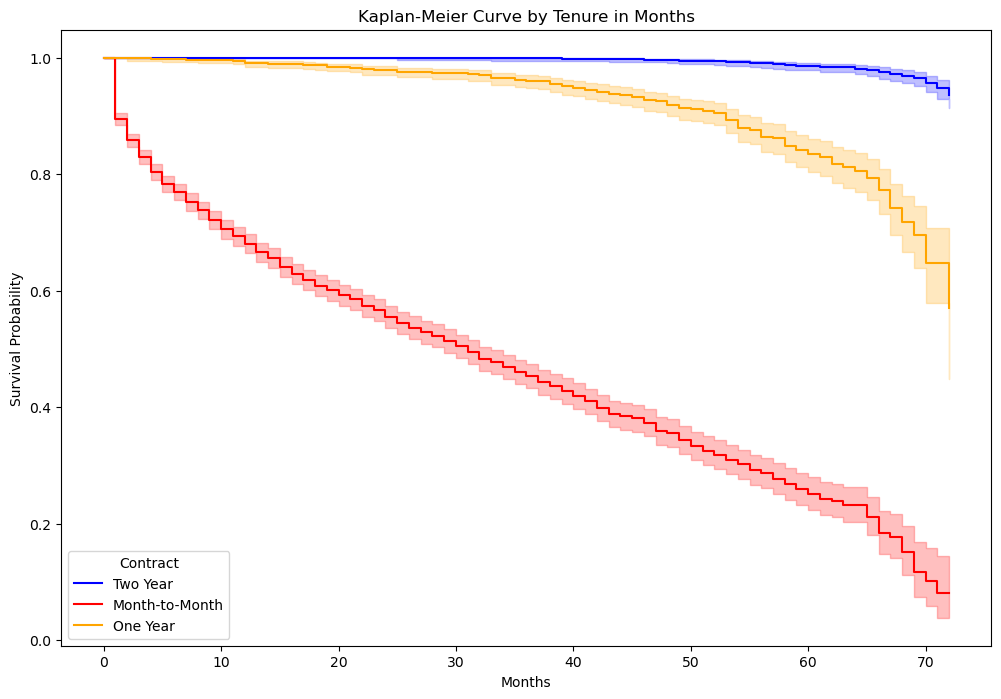

In [118]:
# Instantiate the Kaplan-Meier Fitter model
kmf = KaplanMeierFitter()

# Get a list of unique product categories
categories = data['Contract'].unique()

# Define a color palette (ensure it has enough colors for each category)
colors = ['blue', 'red', 'orange']

# Create a figure for the plots
plt.figure(figsize=(12, 8))

# Loop through each product category with a color for each category
for i, category in enumerate(categories):
    # Filter the data for the current category
    df_new = data[data['Contract'] == category]
    
    # Fit the Kaplan-Meier model on 'Tenure in Months' and 'Churn Value'
    kmf.fit(df_new['TenureInMonths'], df_new['ChurnLabel'])
    
    # Plot the survival curve for the current category with a specific color
    kmf.plot(label=category, color=colors[i % len(colors)])
    
# Add title and labels to the plot
plt.title('Kaplan-Meier Curve by Tenure in Months')
plt.xlabel('Months')
plt.ylabel('Survival Probability')

# Show the legend for each category
plt.legend(title='Contract')

# Display the plot
plt.show()

# Cox Regression

In [298]:
data.columns

Index(['SatisfactionScore', 'ChurnLabel', 'CLTV', 'MonthlyCharge', 'TotalCharges', 'TotalRefunds', 'TotalExtraDataCharges', 'TotalLongDistanceCharges', 'TotalRevenue', 'AvgMonthlyGBDownload', 'AvgMonthlyLongDistanceCharges', 'Gender', 'Age', 'Under30', 'SeniorCitizen', 'Married', 'Dependents', 'NumberOfDependents', 'Population', 'ReferredAFriend', 'NumberOfReferrals', 'TenureInMonths', 'Offer', 'PhoneService', 'MultipleLines', 'InternetService', 'InternetType', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtectionPlan', 'PremiumTechSupport', 'StreamingTV', 'StreamingMovies', 'StreamingMusic', 'UnlimitedData', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'kprototypes_cluster'],
      dtype='object')

In [340]:
# Select Appropriate Columns (columns which we can use to)
df_cox = data[['Population','SeniorCitizen', 'NumberOfDependents', 
 'InternetService', 'Contract', 'PaperlessBilling', 'PremiumTechSupport', 'Under30',
 'MonthlyCharge', 'Age', 'Married','TenureInMonths', 'AvgMonthlyLongDistanceCharges', 
 'AvgMonthlyGBDownload', 'UnlimitedData', 'TotalExtraDataCharges', 'SatisfactionScore', 'ChurnLabel'
 ]]

**Encoding Categorical Data**

In [343]:
df_cox['SeniorCitizen'] = pd.get_dummies(df_cox['SeniorCitizen'], drop_first=True, dtype = 'int')
df_cox['PremiumTechSupport'] = pd.get_dummies(df_cox['PremiumTechSupport'], drop_first=True, dtype = 'int')
df_cox['Married'] = pd.get_dummies(df_cox['Married'], drop_first=True, dtype = 'int')
df_cox['UnlimitedData'] = pd.get_dummies(df_cox['UnlimitedData'], drop_first=True, dtype = 'int')
df_cox['PaperlessBilling'] = pd.get_dummies(df_cox['PaperlessBilling'], drop_first=True, dtype = 'int')

**Encoding Non-Categorical Data**

In [346]:
internet_service = pd.get_dummies(df_cox['InternetService'], drop_first=True, dtype = 'int')
contract = pd.get_dummies(df_cox['Contract'], drop_first=True, dtype = 'int')

In [348]:
concatenated = pd.concat([internet_service, contract],axis=1)

In [350]:
df_cox = pd.concat([df_cox, concatenated],axis=1)

In [352]:
df_cox = df_cox.drop(['InternetService', 'Contract'],axis=1)

In [354]:
df_cox.head()

,Population,SeniorCitizen,NumberOfDependents,PaperlessBilling,PremiumTechSupport,Under30,MonthlyCharge,Age,Married,TenureInMonths,AvgMonthlyLongDistanceCharges,AvgMonthlyGBDownload,UnlimitedData,TotalExtraDataCharges,SatisfactionScore,ChurnLabel,Yes,One Year,Two Year
0,40270,0,0,1,0,1,110.05,27,0,69,5.71,73,1,0.0,3,0,1,0,1
1,404,0,0,1,0,0,76.65,36,0,4,24.09,17,1,0.0,1,1,1,0,0
2,18036,0,1,1,0,0,79.20,53,1,69,21.56,17,1,0.0,4,0,1,0,1
3,261,1,0,1,0,0,85.60,74,1,15,45.25,22,1,0.0,1,1,1,0,0
4,12083,0,2,0,0,0,19.65,48,1,11,40.76,0,0,0.0,3,0,0,0,1


In [356]:
#Checking if all data is numeric
df_cox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Population                     7043 non-null   int64  
 1   SeniorCitizen                  7043 non-null   int32  
 2   NumberOfDependents             7043 non-null   int64  
 3   PaperlessBilling               7043 non-null   int32  
 4   PremiumTechSupport             7043 non-null   int32  
 5   Under30                        7043 non-null   int32  
 6   MonthlyCharge                  7043 non-null   float64
 7   Age                            7043 non-null   int64  
 8   Married                        7043 non-null   int32  
 9   TenureInMonths                 7043 non-null   int64  
 10  AvgMonthlyLongDistanceCharges  7043 non-null   float64
 11  AvgMonthlyGBDownload           7043 non-null   int64  
 12  UnlimitedData                  7043 non-null   i

In [358]:
cph = CoxPHFitter()
cph.fit(df_cox, duration_col='TenureInMonths',event_col='ChurnLabel')
cph.print_summary(style='ascii')

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'TenureInMonths'
                event col = 'ChurnLabel'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12890.46
         time fit was run = 2024-10-29 12:21:00 UTC

---
                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                             
Population                      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
SeniorCitizen                  -0.21       0.81       0.09            -0.39            -0.02                 0.68                 0.98
NumberOfDependents             -0.27       0.76       0.05            -0.37       

# Cox Proportional Hazards Model: Risk Calculation

The Cox Proportional Hazards (Cox PH) model estimates the risk of an event (e.g., churn) based on covariates. Here’s the step-by-step math behind the calculation:

---

## 1. Hazard Function
The Cox PH model assumes the hazard function \( h(t) \) for an individual is:

\[
h(t|X) = h_0(t) \cdot \exp(\beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p)
\]

Where:
- \( h(t|X) \): Hazard at time \( t \) for an individual with covariates \( X = (X_1, X_2, \dots, X_p) \).
- \( h_0(t) \): Baseline hazard function (shared by all individuals).
- \( \beta_i \): Coefficient for covariate \( X_i \).
- \( \exp(\beta_i) \): Hazard ratio (HR) for \( X_i \).

The baseline hazard \( h_0(t) \) is estimated but not directly used for interpreting covariates.

---

## 2. Hazard Ratio
The **hazard ratio** \( \exp(\beta_i) \) for a covariate \( X_i \) represents the **relative risk** associated with a one-unit increase in \( X_i \), holding other variables constant.

- **If \( \beta_i > 0 \)**: The risk increases (\( \exp(\beta_i) > 1 \)).
- **If \( \beta_i < 0 \)**: The risk decreases (\( \exp(\beta_i) < 1 \)).
- **If \( \beta_i = 0 \)**: No effect (\( \exp(\beta_i) = 1 \)).

### Example:
For \( \beta = -0.54 \) (Married):
\[
\text{HR} = \exp(-0.54) \approx 0.59
\]
Being married reduces the risk by \( 1 - 0.59 = 41\% \).

---

## 3. Coefficient Interpretation
The coefficients \( \beta_i \) are estimated during model fitting by maximizing the **partial likelihood** (specific to the Cox model). For \( \beta_i \), a positive value increases the log hazard, while a negative value decreases it.

### Linear Relationship:
\[
\log(h(t|X)) = \log(h_0(t)) + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p
\]

### Back to Hazard:
Exponentiating both sides gives:
\[
h(t|X) = h_0(t) \cdot \exp(\beta_1 X_1 + \dots + \beta_p X_p)
\]

---

## 4. Example Calculations
For each covariate, we interpret \( \beta \) as follows:

### **SeniorCitizen**:
- \( \beta = -0.21 \)
- HR = \( \exp(-0.21) \approx 0.81 \)
- Interpretation: The risk of churn for senior citizens is reduced by \( 1 - 0.81 = 19\% \) compared to non-senior citizens.

### **NumberOfDependents**:
- \( \beta = -0.27 \)
- HR = \( \exp(-0.27) \approx 0.76 \)
- Interpretation: Each dependent reduces churn risk by \( 1 - 0.76 = 24\% \).

### **SatisfactionScore**:
- \( \beta = -0.99 \)
- HR = \( \exp(-0.99) \approx 0.37 \)
- Interpretation: A higher satisfaction score reduces churn risk by \( 1 - 0.37 = 63\% \).

### **Contract Type - Two Year**:
- \( \beta = -3.40 \)
- HR = \( \exp(-3.40) \approx 0.03 \)
- Interpretation: Customers on two-year contracts have a \( 1 - 0.03 = 97\% \) lower risk of churn compared to month-to-month contracts.

---

## 5. Confidence Intervals
The 95% confidence interval for \( \exp(\beta) \) is calculated as:
\[
\exp(\beta_i \pm 1.96 \cdot \text{SE}(\beta_i))
\]

Where \( \text{SE}(\beta_i) \) is the standard error of \( \beta_i \).

### Example:
For SeniorCitizen (\( \beta = -0.21, \text{SE} = 0.09 \)):
- Lower CI = \( \exp(-0.21 - 1.96 \cdot 0.09) = \exp(-0.3864) \approx 0.68 \)
- Upper CI = \( \exp(-0.21 + 1.96 \cdot 0.09) = \exp(-0.0336) \approx 0.98 \)

Interpretation: The true HR is between 0.68 and 0.98 with 95% confidence.

---

## 6. Final Risk Estimation
The overall risk for an individual is computed by plugging their covariates into the hazard function:
\[
h(t|X) = h_0(t) \cdot \exp(\beta_1 X_1 + \dots + \beta_p X_p)
\]
The baseline hazard \( h_0(t) \) is estimated non-parametrically and not explicitly shown here, but it scales the risk for the population.

---



### Key Metrics and Interpretatio (Cox Proportional Hazards)n
1. **Coefficient (`coef`)**:
   - The `coef` (or log-hazard ratio) tells us the relationship between each covariate and the hazard rate (or risk of churn).
   - Positive `coef` values mean that an increase in that variable increases the risk of churn, while negative values suggest a protective effect, lowering the churn risk.

2. **Exponentiated Coefficient (`exp(coef)`)**:
   - `exp(coef)` (hazard ratio) transforms the `coef` into a more interpretable measure: values above 1 suggest a higher hazard or risk of churn, and values below 1 indicate a reduced risk of churn.
   - For example, `exp(coef)` of `0.81` for **SeniorCitizen** means that senior citizens are 19% less likely to churn than non-senior citizens.

3. **Standard Error (`se(coef)`)**:
   - The standard error measures the variability or reliability of the `coef` estimates.
   - Smaller values indicate more confidence in the effect size estimation, while larger values suggest higher variability.

4. **Confidence Intervals (95%)**:
   - `coef lower 95%` and `coef upper 95%` give the range in which the true `coef` value likely lies with 95% confidence.
   - This helps assess the statistical significance and stability of the estimates.

5. **p-value and -log2(p)**:
   - The p-value measures the statistical significance of each covariate. Lower values (typically below 0.05) indicate that the variable significantly influences churn risk.
   - `-log2(p)` gives a log-scaled p-value, making it easier to interpret very small p-values; a high value here suggests strong evidence for the variable's impact.

### Variable Analysis
1. **Population**:
   - Minimal effect on churn, given `coef` and `exp(coef)` are near zero. However, `p < 0.05` indicates slight statistical significance.

2. **SeniorCitizen (-0.21)**:
   - **Interpretation**: Senior citizens show lower churn risk by about 19%.
   - **Insight**: Offering senior-friendly services might help retain this demographic.

3. **NumberOfDependents (-0.27)**:
   - **Interpretation**: More dependents correlate with lower churn risk.
   - **Insight**: Family-oriented services or family discounts may improve retention.

4. **PaperlessBilling (0.02)**:
   - **Interpretation**: Insignificant effect on churn, as `p = 0.77` suggests.
   - **Insight**: Paperless billing does not affect retention noticeably, so it may not need to be a priority.

5. **PremiumTechSupport (-0.26)**:
   - **Interpretation**: Customers with premium support are 23% less likely to churn.
   - **Insight**: Investing in premium support options could reduce churn for customers needing additional help.

6. **Under30 (-0.02)**:
   - **Interpretation**: Insignificant effect, with a p-value of 0.82. The Under-30 group does not differ significantly in churn risk.
   - **Insight**: Age-based retention strategies may be better focused elsewhere.

7. **MonthlyCharge (-0.01)**:
   - **Interpretation**: Higher charges marginally decrease churn.
   - **Insight**: This might suggest a slight preference for higher-tier services; bundling additional services with higher charges could improve retention.

8. **Married (-0.54)**:
   - **Interpretation**: Married customers are 41% less likely to churn.
   - **Insight**: Family or household services might further improve loyalty among married customers.

9. **UnlimitedData (-0.37)**:
   - **Interpretation**: Customers with unlimited data plans are 31% less likely to churn.
   - **Insight**: Offering or promoting unlimited data plans may help retain customers.

10. **SatisfactionScore (-0.99)**:
    - **Interpretation**: The strongest effect, with dissatisfied customers being much more likely to churn.
    - **Insight**: Improving satisfaction scores should be a top priority to retain customers.

11. **Yes (0.76)**:
    - **Interpretation**: Possibly a binary indicator (e.g., Yes for Churn), this shows a high churn risk. `exp(coef)` of 2.15 means these customers are twice as likely to churn.
    - **Insight**: A closer examination of customers marked as "Yes" is needed to identify specific retention strategies.

12. **One Year (-1.56) and Two Year (-3.40)**:
    - **Interpretation**: Long-term contracts dramatically reduce churn.
    - **Insight**: Promoting one- and two-year contracts is beneficial for retention.

### Recommendations and Assumptions
1. **Focus on Satisfaction**: Since **SatisfactionScore** has a substantial effect on churn, consider implementing loyalty programs, enhancing customer service, and addressing pain points in services to improve this score.

2. **Promote Long-Term Contracts**: The significant reduction in churn risk for one- and two-year contracts suggests that incentivizing customers to commit to longer-term plans could reduce churn.

3. **Offer Unlimited Data Options**: The data shows **UnlimitedData** reduces churn risk, so offering affordable unlimited data options or promoting these plans might help retain customers.

4. **Understand "Yes" Customers**: The high risk associated with "Yes" customers suggests they might represent an at-risk group. Identifying characteristics unique to these customers could help develop targeted retention strategies.

5. **Target Married and Family-Oriented Services**: Since married customers are less likely to churn, expanding family-oriented plans could help improve retention in this group.

The high **concordance score of 0.92** suggests the model fits the data well, and the partial AIC value offers a measure for comparing with other models if necessary. This analysis can guide retention efforts by focusing on satisfaction, incentivizing long-term contracts, and creating targeted offers for senior citizens, married customers, and families.

Hi Chat Gpt I am a data scientist and I just performed a Cox proportional hazards regression analysis, and I would like a comprehensive interpretation of the results. Below is the output from my model:

1. Analyze the coefficients (coef) and explain what each score means for its corresponding variable, especially in terms of the variable's impact on the hazard of the event occurring.
2. Explain the interpretation of exp(coef) (the hazard ratio) and how it relates to the direction and magnitude of the variable's effect.
3. Discuss the statistical significance of each variable, referencing the z-scores and p-values.
4. Provide insights into how the scores were derived, including the role of partial log-likelihood, baseline estimation, and other relevant metrics.
5. Highlight the concordance score, partial AIC, and log-likelihood ratio test, explaining their relevance to model performance and fit.
6. Based on the analysis, provide practical recommendations or assumptions that can be drawn from the regression output, particularly regarding the variables that significantly affect the event.
The Cox regression was fitted using the following columns:

Duration Column: 'TenureInMonths'
Event Column: 'ChurnLabel'
Please ensure the explanation is detailed, includes examples if necessary, and provides actionable insights.



# Building Supervised Machine Learning Model

In [163]:
df_supervised = df_model

In [165]:
df_supervised.head()

,SatisfactionScore,ChurnLabel,CLTV,MonthlyCharge,TotalCharges,TotalRefunds,TotalExtraDataCharges,TotalLongDistanceCharges,TotalRevenue,AvgMonthlyGBDownload,AvgMonthlyLongDistanceCharges,Gender,Age,Under30,SeniorCitizen,Married,Dependents,NumberOfDependents,Population,ReferredAFriend,NumberOfReferrals,TenureInMonths,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtectionPlan,PremiumTechSupport,StreamingTV,StreamingMovies,StreamingMusic,UnlimitedData,PaperlessBilling,Offer_Offer A,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E,InternetType_DSL,InternetType_Fiber Optic,InternetType_None,Contract_One Year,Contract_Two Year,PaymentMethod_Credit Card,PaymentMethod_Mailed Check
0,3,0,5798,110.05,7430.75,23.16,0.0,393.99,7801.58,73,5.71,1,27,1,0,0,0,0,40270,0,0,69,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,1,1,0
1,1,1,4580,76.65,333.60,0.00,0.0,96.36,429.96,17,24.09,0,36,0,0,0,0,0,404,0,0,4,1,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
2,4,0,4072,79.20,5420.65,0.00,0.0,1487.64,6908.29,17,21.56,1,53,0,0,1,1,1,18036,1,5,69,1,1,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,1,1,0
3,1,1,4981,85.60,1345.55,0.00,0.0,678.75,2024.30,22,45.25,1,74,0,1,1,0,0,261,1,1,15,1,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,3,0,3372,19.65,225.75,0.00,0.0,448.36,674.11,0,40.76,1,48,0,0,1,1,2,12083,1,2,11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0


In [167]:
df_supervised.corr()

,SatisfactionScore,ChurnLabel,CLTV,MonthlyCharge,TotalCharges,TotalRefunds,TotalExtraDataCharges,TotalLongDistanceCharges,TotalRevenue,AvgMonthlyGBDownload,AvgMonthlyLongDistanceCharges,Gender,Age,Under30,SeniorCitizen,Married,Dependents,NumberOfDependents,Population,ReferredAFriend,NumberOfReferrals,TenureInMonths,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtectionPlan,PremiumTechSupport,StreamingTV,StreamingMovies,StreamingMusic,UnlimitedData,PaperlessBilling,Offer_Offer A,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E,InternetType_DSL,InternetType_Fiber Optic,InternetType_None,Contract_One Year,Contract_Two Year,PaymentMethod_Credit Card,PaymentMethod_Mailed Check
SatisfactionScore,1.000000,-0.754649,0.075811,-0.223922,0.068950,0.024221,-0.010472,0.136783,0.094796,-0.091657,0.001146,-0.003948,-0.085170,0.041993,-0.116601,0.077743,0.168359,0.152873,-0.031061,0.077764,0.188926,0.210557,0.013601,-0.054236,-0.264526,-0.093158,0.003252,-0.000549,0.050086,-0.083323,-0.086121,-0.073268,-0.210489,-0.156436,0.070783,0.070655,0.014731,0.000235,-0.130047,0.025764,-0.224146,0.264526,0.147564,0.221553,0.165131,-0.039140
ChurnLabel,-0.754649,1.000000,-0.127463,0.193356,-0.198546,-0.033709,0.007139,-0.223756,-0.223003,0.048868,0.008120,-0.008612,0.115760,-0.054604,0.150889,-0.150448,-0.248542,-0.218780,0.051655,-0.149122,-0.286540,-0.352861,0.011942,0.040102,0.227890,-0.171226,-0.082255,-0.066160,-0.164674,0.063228,0.061382,0.045587,0.166545,0.191825,-0.126654,-0.117723,-0.020660,0.001435,0.214648,-0.099716,0.279623,-0.227890,-0.190418,-0.328195,-0.218528,0.056348
CLTV,0.075811,-0.127463,1.000000,0.098693,0.341947,0.007992,0.042540,0.282189,0.354198,0.023043,0.023858,-0.006851,-0.001826,-0.008363,-0.003167,0.137859,0.058222,0.049611,-0.000654,0.125249,0.122843,0.396292,0.023015,0.133568,0.011521,0.138354,0.138610,0.120394,0.119132,0.104889,0.113000,0.096560,-0.001685,0.011501,0.192939,0.135031,-0.074511,-0.096737,-0.098298,0.014095,0.012723,-0.011521,0.045028,0.215159,0.014113,-0.059070
MonthlyCharge,-0.223922,0.193356,0.098693,1.000000,0.651236,0.033482,0.126244,0.246300,0.588887,0.391787,0.138396,-0.014569,0.144685,-0.044466,0.220173,0.096848,-0.144206,-0.131837,0.009602,0.094101,0.028173,0.247582,0.247398,0.490434,0.763557,0.296594,0.441780,0.482692,0.338304,0.629603,0.627429,0.536270,0.582484,0.352150,0.121596,0.073414,0.015108,-0.066988,-0.103075,-0.121034,0.774253,-0.763557,0.015829,-0.046554,-0.235459,-0.136941
TotalCharges,0.068950,-0.198546,0.341947,0.651236,1.000000,0.039558,0.121859,0.610185,0.972212,0.223268,0.069500,-0.000152,0.059684,-0.014157,0.102907,0.317777,0.030807,0.022535,-0.006436,0.304199,0.250378,0.826074,0.113106,0.468615,0.375269,0.411922,0.509507,0.522255,0.432146,0.515217,0.520130,0.440462,0.288220,0.158442,0.394442,0.243143,-0.025051,-0.182043,-0.327334,-0.037180,0.364414,-0.375269,0.165968,0.344976,-0.036995,-0.135690
TotalRefunds,0.024221,-0.033709,0.007992,0.033482,0.039558,1.000000,0.016755,0.028113,0.036984,0.002397,-0.018644,0.004725,0.024168,-0.012096,0.028565,0.040142,0.021652,0.014023,0.019639,0.038250,0.024756,0.059021,0.006331,0.045491,0.020515,0.008190,0.016855,0.026038,0.034823,0.021796,0.013587,0.003212,0.011101,0.003966,0.001645,0.004892,0.010928,-0.006733,-0.052626,0.004102,0.022214,-0.020515,0.010797,0.043560,-0.020157,-0.023992
TotalExtraDataCharges,-0.010472,0.007139,0.042540,0.126244,0.121859,0.016755,1.000000,0.058871,0.122496,0.088939,0.002414,-0.001921,0.025036,0.012301,0.032917,0.017882,-0.015733,-0.014436,0.012031,0.020150,0.000350,0.082266,-0.030620,0.064443,0.143736,0.058889,0.095852,0.073985,0.087941,0.072300,0.094445,0.079644,-0.392720,0.038718,0.027738,0.018068,0.016160,0.012540,-0.065469,0.057213,0.063250,-0.143736,0.026293,-0.010846,-0.035828,-0.033375
TotalLongDistanceCharges,0.136783,-0.223756,0.282189,0.246300,0.610185,0.028113,0.058871,1.000000,0.778559,0.011373,0.599828,0.011092,0.003065,-0.001714,0.010534,0.264230,0.085965,0.068

In [169]:
# Step 1: Compute the correlation matrix
correlation_matrix = df_supervised.corr()

# Step 2: Set a correlation threshold (for example, 0.8 or higher for "high correlation")
threshold = 0.8

# Step 3: Find pairs of highly correlated values
# We'll iterate through the correlation matrix and store pairs where the correlation is greater than the threshold.
high_corr_pairs = []

# Iterate through the upper triangle of the correlation matrix to avoid duplicate pairs
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            high_corr_pairs.append((colname_i, colname_j, correlation_matrix.iloc[i, j]))

# Step 4: Display the highly correlated pairs
if high_corr_pairs:
    print("Highly correlated pairs:")
    for pair in high_corr_pairs:
        print(f"{pair[0]} and {pair[1]}: correlation = {pair[2]}")
else:
    print("No highly correlated pairs found.")

Highly correlated pairs:
TotalCharges and TotalRevenue: correlation = 0.9722121080286065
TotalCharges and TenureInMonths: correlation = 0.8260735088595978
TotalRevenue and TenureInMonths: correlation = 0.8531462752059287
Married and ReferredAFriend: correlation = 0.9499865007311682
Dependents and NumberOfDependents: correlation = 0.888233726647447
InternetService and InternetType_None: correlation = -1.0000000000000004
StreamingMovies and StreamingMusic: correlation = 0.8485281327010226


In [173]:
df_supervised = df_supervised.drop(['TotalRevenue','ReferredAFriend','NumberOfDependents','InternetService','StreamingMovies'],axis=1)

In [171]:
df_supervised.columns

Index(['SatisfactionScore', 'ChurnLabel', 'CLTV', 'MonthlyCharge', 'TotalCharges', 'TotalRefunds', 'TotalExtraDataCharges', 'TotalLongDistanceCharges', 'TotalRevenue', 'AvgMonthlyGBDownload', 'AvgMonthlyLongDistanceCharges', 'Gender', 'Age', 'Under30', 'SeniorCitizen', 'Married', 'Dependents', 'NumberOfDependents', 'Population', 'ReferredAFriend', 'NumberOfReferrals', 'TenureInMonths', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtectionPlan',
       'PremiumTechSupport', 'StreamingTV', 'StreamingMovies', 'StreamingMusic', 'UnlimitedData', 'PaperlessBilling', 'Offer_Offer A', 'Offer_Offer B', 'Offer_Offer C', 'Offer_Offer D', 'Offer_Offer E', 'InternetType_DSL', 'InternetType_Fiber Optic', 'InternetType_None', 'Contract_One Year', 'Contract_Two Year', 'PaymentMethod_Credit Card', 'PaymentMethod_Mailed Check'],
      dtype='object')

In [175]:
X = df_supervised.drop('ChurnLabel',axis=1)
y = df_supervised['ChurnLabel']

In [177]:
df_supervised['ChurnLabel'].value_counts()

ChurnLabel
0    5174
1    1869
Name: count, dtype: int64

In [179]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split

# Split data (optional)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Resample the training data
X_train, y_train = smote.fit_resample(X_train, y_train)

# Show the counts of the original and resampled data
print(f"Original dataset shape: {Counter(y_train)}")
print(f"Resampled dataset shape: {Counter(y_train)}")


Original dataset shape: Counter({0: 3628, 1: 3628})
Resampled dataset shape: Counter({0: 3628, 1: 3628})


In [181]:
model = LogisticRegression()

In [183]:
model.fit(X_train,y_train)

LogisticRegression()

In [185]:
predictions = model.predict(X_test)

In [187]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.89      0.74      0.80      1546
           1       0.51      0.74      0.60       567

    accuracy                           0.74      2113
   macro avg       0.70      0.74      0.70      2113
weighted avg       0.78      0.74      0.75      2113



In [189]:
print('precision:',precision_score(y_test, predictions))
print('F1:',f1_score(y_test, predictions))
print('recall:',recall_score(y_test, predictions))
print('Accuracy:',accuracy_score(y_test, predictions))

precision: 0.5084541062801933
F1: 0.603584229390681
recall: 0.7425044091710759
Accuracy: 0.7382867960246096


# Trying Other Models

LR: 0.787877 (0.010711)
LDA: 0.957545 (0.007343)
KNN: 0.700413 (0.011288)
CART: 0.943346 (0.007382)
RF: 0.962656 (0.006521)
NB: 0.848355 (0.013698)
SVM: 0.734630 (0.013458)


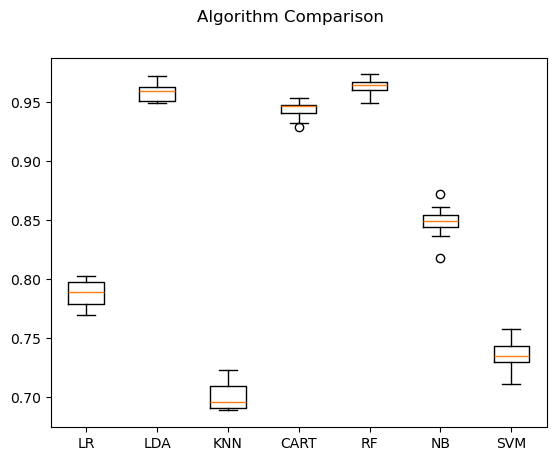

In [192]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn import model_selection

# prepare configuration for cross validation test harness


# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy' # or, better still fbeta
for name, model in models:
	kfold = model_selection.KFold(n_splits=10)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Random Forest Classifier

In [195]:
model_two = RandomForestClassifier()

In [197]:
model_two.fit(X_train, y_train)

RandomForestClassifier()

In [198]:
predictions = model_two.predict(X_test)

In [199]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1546
           1       0.96      0.87      0.92       567

    accuracy                           0.96      2113
   macro avg       0.96      0.93      0.94      2113
weighted avg       0.96      0.96      0.96      2113



In [200]:
print('precision:',precision_score(y_test, predictions))
print('F1:',f1_score(y_test, predictions))
print('recall:',recall_score(y_test, predictions))
print('Accuracy:',accuracy_score(y_test, predictions))

precision: 0.96484375
F1: 0.9156626506024096
recall: 0.8712522045855379
Accuracy: 0.9569332702318978


In [202]:
# Get feature importance
feature_importances = model_two.feature_importances_

# Create a DataFrame to display feature importance
features = X.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the result
print(importance_df)

                          Feature  Importance
0               SatisfactionScore    0.475597
37              Contract_Two Year    0.067247
16              NumberOfReferrals    0.051041
38      PaymentMethod_Credit Card    0.038716
17                 TenureInMonths    0.035753
7            AvgMonthlyGBDownload    0.031312
2                   MonthlyCharge    0.030059
14                     Dependents    0.026478
20                 OnlineSecurity    0.026305
36              Contract_One Year    0.023297
35              InternetType_None    0.022054
3                    TotalCharges    0.018919
6        TotalLongDistanceCharges    0.018004
23             PremiumTechSupport    0.016035
10                            Age    0.013828
1                            CLTV    0.013390
15                     Population    0.013349
8   AvgMonthlyLongDistanceCharges    0.011480
33               InternetType_DSL    0.010057
21                   OnlineBackup    0.008866
13                        Married 

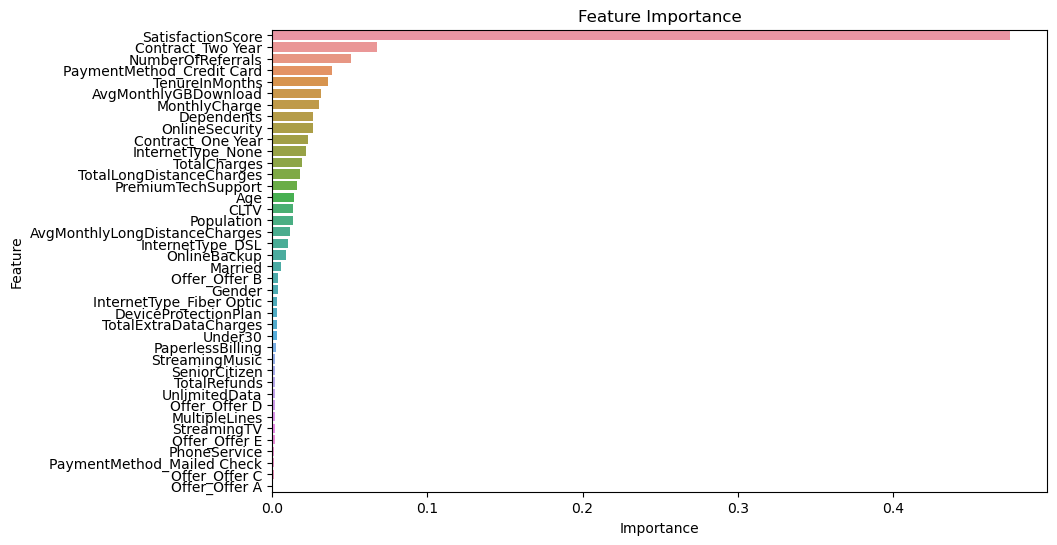

In [207]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()